## 梯度下降
尽管梯度下降（gradient descent）很少直接⽤于深度学习，但了解它是理解下⼀节随机梯度下降算法的
关键。例如，由于学习率过⼤，优化问题可能会发散，这种现象早已在梯度下降中出现。同样地，预处理
（preconditioning）是梯度下降中的⼀种常⽤技术，还被沿⽤到更⾼级的算法中。让我们从简单的⼀维梯度
下降开始。

#### 一维梯度下降
为什么梯度下降算法可以优化⽬标函数？⼀维中的梯度下降给我们很好的启发。考虑⼀类连续可微实值函
数f : R → R，利⽤泰勒展开，我们可以得到

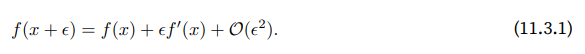

即在⼀阶近似中，f(x + ϵ)可通过x处的函数值f(x)和⼀阶导数f′(x)得出。我们可以假设在负梯度⽅向上移动
的ϵ会减少f。为了简单起⻅，我们选择固定步⻓η > 0，然后取ϵ = −ηf′(x)。将其代⼊泰勒展开式我们可以得到

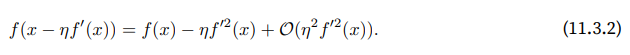

如果其导数f′(x) ̸= 0没有消失，我们就能继续展开，这是因为ηf′2
(x) > 0。此外，我们总是可以令η⼩到⾜以使⾼阶项变得不相关。因此，

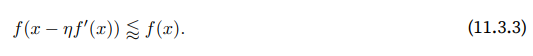

这意味着，如果我们使⽤  
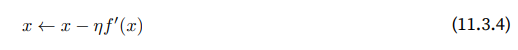

来迭代x，函数f(x)的值可能会下降。因此，在梯度下降中，我们⾸先选择初始值x和常数η > 0，然后使⽤它
们连续迭代x，直到停⽌条件达成。例如，当梯度|f′(x)|的幅度⾜够⼩或迭代次数达到某个值时。
下⾯我们来展⽰如何实现梯度下降。为了简单起⻅，我们选⽤⽬标函数f(x) = x
2。尽管我们知道x = 0时f(x)能
取得最⼩值，但我们仍然使⽤这个简单的函数来观察x的变化。


In [1]:

import numpy as np
import torch
from d2l import torch as d2l

def f(x): # ⽬标函数
    return x ** 2

def f_grad(x): # ⽬标函数的梯度(导数)
    return 2 * x



接下来，我们使⽤x = 10作为初始值，并假设η = 0.2。使⽤梯度下降法迭代x共10次，我们可以看到，x的值
最终将接近最优解。


In [4]:
def gd(eta, f_grad):
    x = 10.0

    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results


results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进⾏x优化的过程可以绘制如下。

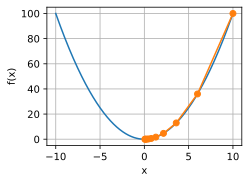

In [5]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)
